In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,MaxPooling2D,Activation
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/Mask Dataset/Data"

'Correctly Masked'  'Incorrectly Masked'  'No Mask'


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
img_height,img_width=224,224
batch_size= 32
classify_names = ['Correctly Masked', 'Incorrectly Masked', 'No Mask']

In [6]:
image_path = '/content/drive/My Drive/Mask Dataset/Data'
model_path = '/content/drive/My Drive/models/'

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  labels='inferred',
  label_mode='int',
  class_names=classify_names,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14997 files belonging to 3 classes.
Using 10498 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  labels='inferred',
  label_mode='int',
  class_names=classify_names,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14997 files belonging to 3 classes.
Using 4499 files for validation.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from keras.layers.serialization import activation
def get_model():
  resnet_model = Sequential()

  pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                   input_shape=(224, 224,3),
                                                   pooling='avg',classes=3,
                                                   weights='imagenet')
  for layer in pretrained_model.layers:
    layer.trainanble=False

  resnet_model.add(pretrained_model)
  resnet_model.add(Flatten())
  resnet_model.add(Dense(512,activation = 'relu'))
  resnet_model.add(Dropout(0.3))
  resnet_model.add(Dense(3, activation='softmax'))
  resnet_model.compile(optimizer=Adam(learning_rate = 0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

  resnet_model.summary()

  return resnet_model

In [ ]:
# from tensorflow.keras.applications import VGG16

# from keras.layers.serialization import activation
# def get_model():
#   VGG16_model = Sequential()

#   pretrained_model = tf.keras.applications.VGG16(include_top = False,
#                                                    input_shape=(224, 224,3),
#                                                    pooling='avg',classes=3,
#                                                    weights='imagenet')
#   for layer in pretrained_model.layers:
#     layer.trainanble=False

#   VGG16_model.add(pretrained_model)
#   VGG16_model.add(Flatten())
#   VGG16_model.add(Dense(512,activation = 'relu'))
#   VGG16_model.add(Dropout(0.5))
#   VGG16_model.add(Dense(256,activation = 'relu'))
#   VGG16_model.add(Dropout(0.5))
#   VGG16_model.add(Dense(3, activation='softmax'))
#   VGG16_model.compile(optimizer=Adam(learning_rate = 0.001),
#                        loss='sparse_categorical_crossentropy',
#                        metrics = ['accuracy'])

#   VGG16_model.summary()

#   return VGG16_model

In [ ]:
# from tensorflow.keras.applications import VGG16

# #4 Adding Custom Layers for Specific Task (Classification)
# from keras.layers.serialization import activation
# def get_model():
#   base_model = VGG16(weights='imagenet', include_top = False, input_shape=(224,224,3))

#   pretrained_model = tf.keras.applications.ResNet50(include_top = False,
#                                                    input_shape=(224, 224,3),
#                                                    pooling='avg',classes=3,
#                                                    weights='imagenet')

# # adding dense layers
# x = Flatten()(base_model.output)
# x = Dense(512, activation = 'relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256,activation = 'relu')(x)
# x = Dropout(0.5)(x)
# output = Dense(3, activation = 'softmax')(x)

# #5 Creating the Extended Model
# model = Model(inputs = base_model.input, outputs = output)

# #6 Complile Model
# from keras.api._v2.keras import metrics
# model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# #7 Summary of Model
# model.summary()

In [ ]:
# from keras.api._v2.keras import callbacks

# from IPython.core import history

with tf.device('/device:GPU:0'):
  resnet_model = get_model()

  history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=EarlyStopping(monitor='val_loss', patience=30))

from matplotlib import pyplot as plt
plt.plot(history.history['loss'], 'r', label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')

plt.xlabel('Epochs')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], 'r', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

resnet_model.save(model_path+'ResNet_3_categories.h5')


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 24,585,219
Non-trainable params: 53,120
________________________________________

In [ ]:
# from matplotlib import pyplot as plt
# plt.plot(history.history['loss'], 'r', label = 'training loss')
# plt.plot(history.history['val_loss'], label = 'validation loss')

# plt.title('Model Loss')
# plt.ylabel('Loss')

# plt.xlabel('Epochs')
# plt.legend()
# plt.show()


# plt.plot(history.history['accuracy'], 'r', label = 'training accuracy')
# plt.plot(history.history['val_accuracy'], label = 'validation accuracy')

# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend()
# plt.show()

# resnet_model.save(model_path+'ResNet_3_categories.h5')

NameError: ignored

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,MaxPooling2D,Activation
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.platform.test import test_src_dir_path
test_path = '/content/drive/My Drive/Mask Dataset/Test/'
test_model_path = '/content/drive/My Drive/models/'


In [ ]:
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D, Conv2D, Input
from keras.preprocessing import image

saved_model = load_model(test_model_path+'ResNet_3_categories.h5')

In [ ]:
import numpy as np
y_pred = [] #store predicted labels
y_true = [] #store true labels

for image_batch, label_batch in val_ds:
  y_true.append(label_batch)
  preds = saved_model.predict(image_batch)
  y_pred.append(np.argmax(preds, axis = -1))


1/1 [==============================] - 1s 1s/step


In [ ]:
import tensorflow
true_categories = tensorflow.concat([item for item in y_true], axis = 0)
predicted_categories = tensorflow.concat([item for item in y_pred], axis = 0)


In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(true_categories, predicted_categories, normalize='pred')

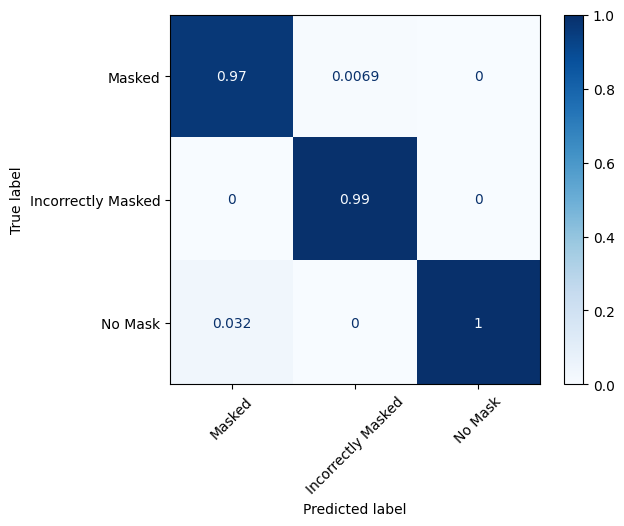

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classify_names)

disp = disp.plot(cmap = 'Blues', xticks_rotation=45)

plt.show()